## Libraries

In [80]:
import numpy as np
import pandas as pd

# We import the sk learn modules we'll need to segment our new data. We'll need scaler, pca and k-means.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# We import pickle in order to be able to load our pickled objects.
import pickle
# We import the Logistic Regression module from sk learn for the purchase probability model.
from sklearn.linear_model import LogisticRegression 
#We import the necessary libraries for visualization. We set seaborn do be our default.
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()
# We import the Linear Regression module from sk learn for the quantity model.
from sklearn.linear_model import LinearRegression

## Data Preparation

In [81]:
#load data
df_purchase = pd.read_csv('purchase data.csv')

# Import Scaler
scaler = pickle.load(open('scaler.pickle', 'rb'))
# Import PCA
pca = pickle.load(open('pca.pickle', 'rb'))
# Import K-Means
kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))

# Standardization variables using standard scaler trained previously
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)

# Apply PCA model which was trained previously
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)

# Predicting Segment labels using k-means model trained previously
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

# Create a copy of the data frame
df_purchase_predictors = df_purchase.copy()

# Add segment labels column
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca

# Create dummy variables for segment  
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')

# Concatenate dummy with orginal dataset
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

# Create new dataset 
df_pa = df_purchase_predictors

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  del sys.path[0]


## Purchase Probability Model

In [82]:
# In order to predict we need input and output variables. 
# Our Y is Purchase Incidence, as we want to predict the purchase probability for our customers
Y = df_pa['Incidence']

In [83]:
pd.options.display.max_columns=None
df_pa.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0


In [84]:
# Our dependant variable is based on the average price of chocolate candy bars. 
# Therefore, X is a data frame, containing the mean across the five prices.
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5

In [85]:
# We create a Logistic Regression model using sk learn. Then we fit the model with our X or price and our Y or incidence.
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [86]:
# The coefficients for price. It is negative, signaling that with an increase in mean prices,
# the purchase probability decreases.
model_purchase.coef_

array([[-2.34784716]])

## Price Elasticity of Purchase Probability

In [87]:
# Here we see the prices for the five different brands, which is an important factor in determining purchase probability. 
# It informs the price range, for which we will be exploring purchase probability.
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [88]:
# We introduce the price range for which we'll examine the purchase probability.
# We choose a price range between 0.5 and 3.49, which somewhat expands the actual observed price range, 
# which is from 1.1 to 2.8 to how elasticity change with change in price.
price_range = np.arange(0.5, 3.5, 0.01)
price_range

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
       0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04,
       1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37,
       1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48,
       1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59,
       1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 ,
       1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81,
       1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92,
       1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.

In [89]:
df_price_range = pd.DataFrame(price_range)

## Price elasticity by defination means % change in the purchase probability in response to the 1% change in the price.
# i.e Elasticity = delta (Purchase Prob)/ Purchase Prob :/: delta (Price) / Price

# The simplified formula for elasticity is 
# Elasticity = beta_coef * price * (1 - Purchase Prob)

In [90]:
# We predict the purchase probability for our newly defined price range. 
# The result is a 2x300  array. The first column shows the probability for not purchasing the product, 
# the second the probability for purchase for each price point in our price range.
Y_pr = model_purchase.predict_proba(df_price_range)
purchase_pr = Y_pr[:][:, 1]

# Calculate the price elasticity using the elasticity formula
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

In [91]:
# Create price elasticities master data frame.
# It will contain all the elasticities value that we calculate throughout.
df_price_elasticities = pd.DataFrame(price_range)

In [92]:
pd.options.display.max_rows = None
df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['Mean_PE'] = pe
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096372
1,0.51,-0.100439
2,0.52,-0.104633
3,0.53,-0.108957
4,0.54,-0.113414
5,0.55,-0.118008
6,0.56,-0.122741
7,0.57,-0.127618
8,0.58,-0.132641
9,0.59,-0.137814


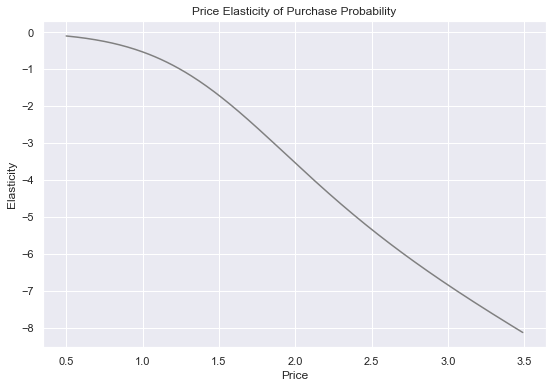

In [93]:
# We display the price elasticity of purchase probability of the average customer.
# We observe that the price elasticities are all negative. Furthermore we can spot where the customer becomes inelastic.
# But to find the precise spot we can consult the price elasticities data frame.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

From the elasticity graph, it can be observed that the elasticities are negative indicating that effect of price is inversely proportional to the elasticity. Also it can be seen that the rate of decrease is less steep between 0.5 to 1.1 and more steep afterwards. 
# By defination, if the elasticity value > 100% or |1| then it means its Elastic else Non- Elastic

By Figure, it can be seen that customer become elastic at approx 1.25 price point and from the dataset above, it can be seen that at 1.10 price (which was our min price), the elasiticity value is -0.69, meaning that with 1% increase in prices, the purchase probability decrease by 0.69% (which is less than 1% so it is inelastic at this price point). However, for the higher price point such as 1.50, the value is -1.70%, meaning that increase in price by 1% will now lead to decrease in purchase probability of 1.7% (which is greater than 1% so it is elastic at this price point)

The General recommendation is that we could increase the prices until 1.25 safely without much concerning about the purchase probability since it is inelastic till this price point. However, at higher than this price point, further increase in the price point will lead to significant decrease in purchase probability since it is inelastic at this price points. 

## Since the is the analysis of average customers, it gives us little insight about the different types of customer. To further refine our analysis, we need to perform the same analysis for each of the different segment of our customers to see that at which price point they become inelastic, to further augment our marketing strategy.

## Purchase Probability by Segments

### $\color{Blue}{\textbf{Segment 3 - Career-Focused}}$

In [94]:
df_segm_pca_kmeans_freq = df_pa.groupby(['Segment']).mean()
df_segm_pca_kmeans_freq

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment_0,Segment_1,Segment_2,Segment_3
Segment,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.000002e+08,350.824750,0.200093,0.469923,0.553803,0.465736,0.198232,1.391593,1.778860,2.007155,2.159746,2.655301,0.347848,0.318679,0.045359,0.118027,0.035264,0.274064,0.098674,35.980554,0.766783,96654.659642,0.280391,0.049081,1,0,0,0
1,2.000003e+08,349.066980,0.211581,0.562897,0.662047,0.560175,0.210344,1.392221,1.782914,2.007025,2.159713,2.655297,0.342902,0.307432,0.043636,0.116225,0.038274,0.891034,0.913140,29.472408,1.053947,108731.349418,0.683164,0.412192,0,1,0,0
2,2.000003e+08,349.762070,0.294998,1.149630,0.898913,1.144585,0.293693,1.392999,1.781336,2.006464,2.160836,2.654993,0.340670,0.321792,0.042018,0.118921,0.036451,0.480296,0.671596,54.937016,2.106916,160577.416181,1.185994,1.102479,0,0,1,0
3,2.000002e+08,347.269956,0.322607,1.429676,0.762224,1.427835,0.322018,1.391922,1.782389,2.006273,2.159714,2.653390,0.341016,0.312813,0.038660,0.118115,0.034168,0.032032,0.159205,37.904050,0.823049,140623.871355,1.288513,1.455965,0,0,0,1


In [95]:
# From our segmentation model, it is clear that 0, 1, 2, 3 segments 
# corresponds to fewer-opportunity, Standard, Well-off, career-focussed
# mapping those labels to each segment.
df_pa['Segment Label'] = df_pa['Segment'].map({0: 'Fewer opportunity',
                                              1 : 'Standard',
                                              2 : 'Well-off',
                                              3 : 'Career-focussed'})
df_pa.head(10)

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Segment Label
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
5,200000001,23,0,0,0,0,0,1.50,1.90,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,2.09,2.67,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
7,200000001,37,0,0,0,2,1,1.50,1.90,1.99,2.09,2.67,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
8,200000001,41,0,0,0,0,0,1.35,1.58,1.97,2.09,2.67,1,1,1,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
9,200000001,43,0,0,0,0,0,1.35,1.58,1.97,2.09,2.67,1,1,1,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity


In [96]:
# We filter the data to contain only customers from segment 3, the career-focused.
# From our segment
df_pa_segment_3 = df_pa[df_pa['Segment Label'] == 'Career-focussed']
df_pa_segment_3.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Segment Label
370,200000005,7,0,0,0,0,0,1.59,1.88,2.01,2.09,2.66,0,0,0,0,0,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed
371,200000005,13,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed
372,200000005,20,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed
373,200000005,32,0,0,0,0,0,1.50,1.90,1.99,2.09,2.67,0,0,0,0,0,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed
374,200000005,39,0,0,0,0,0,1.50,1.90,1.99,2.09,2.67,0,1,0,0,0,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed


In [97]:
# Again we want to predict the purchase probability, so our Y variable is the incidence column.
# Only here we select only the customers from the first segment.
Y = df_pa_segment_3['Incidence']

In [98]:
X = pd.DataFrame()

In [99]:
# We calculate the average price for purchases in segment 3. Our dependant variable contains the mean price of the brands.
X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5

In [100]:
# Fit logistic regression model
model_incidence_segment_3 = LogisticRegression(solver = 'sag')
model_incidence_segment_3.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [101]:
# We observe that the price coefficient for the career focused is -1.7, whereas for the average customer it was -2.35.
# This is an indicator, that this segment is less price sensitive compared to the average customer.
model_incidence_segment_3.coef_

array([[-1.71136454]])

In [102]:
# Calculate Price Elasticity of the career-focused segment.
Y_segment_3 = model_incidence_segment_3.predict_proba(df_price_range)
purchase_pr_segment_3 = Y_segment_3[:, 1]
pe_segment_3 = model_incidence_segment_3.coef_[:, 0] * price_range * (1 - purchase_pr_segment_3)

### Results

In [103]:
df_price_elasticities['PE_Segment_CF'] = pe_segment_3
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF
0,0.50,-0.096372,-0.119130
1,0.51,-0.100439,-0.123314
2,0.52,-0.104633,-0.127591
3,0.53,-0.108957,-0.131962
4,0.54,-0.113414,-0.136430
5,0.55,-0.118008,-0.140996
6,0.56,-0.122741,-0.145661
7,0.57,-0.127618,-0.150427
8,0.58,-0.132641,-0.155294
9,0.59,-0.137814,-0.160266


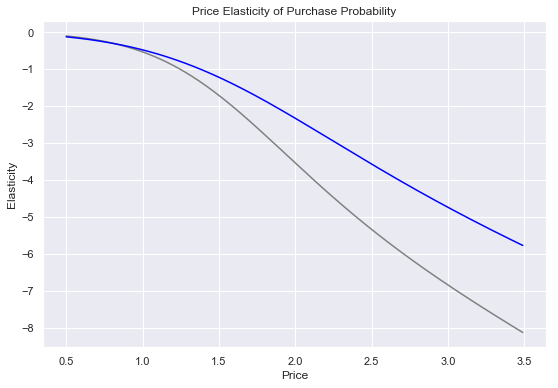

In [104]:
# We plot the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in blue. The same color we used during the descriptive analysis.
plt.figure(figsize = (9, 6))
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['Mean_PE'], color = 'grey')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_CF'], color = 'blue')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

### From the graph, it is evident that career focussed segment is less price sensitive than the average customer and that it becomes inelastic at higher price point (1.39) as compared to (1.25) for average customers.

### $\color{red}{\textbf{Segment 0 - Fewer-Opportunities}}$

In [105]:
# Select only customers from segment 0, the fewer-opportunities.
df_pa_segment_0 = df_pa[df_pa['Segment Label'] == 'Fewer opportunity']

In [106]:
# Logistic regression model
Y = df_pa_segment_0['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5

model_incidence_segment0 = LogisticRegression(solver = 'sag')
model_incidence_segment0.fit(X, Y)

# Calculate price elasticities
model_incidence_segment0.coef_
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[: , 1]
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range * ( 1- purchase_pr_segment0)

### Results

In [107]:
df_price_elasticities['PE_Segment_Few'] = pe_segment0
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few
0,0.50,-0.096372,-0.119130,-0.030930
1,0.51,-0.100439,-0.123314,-0.032698
2,0.52,-0.104633,-0.127591,-0.034552
3,0.53,-0.108957,-0.131962,-0.036497
4,0.54,-0.113414,-0.136430,-0.038537
5,0.55,-0.118008,-0.140996,-0.040676
6,0.56,-0.122741,-0.145661,-0.042918
7,0.57,-0.127618,-0.150427,-0.045269
8,0.58,-0.132641,-0.155294,-0.047731
9,0.59,-0.137814,-0.160266,-0.050312


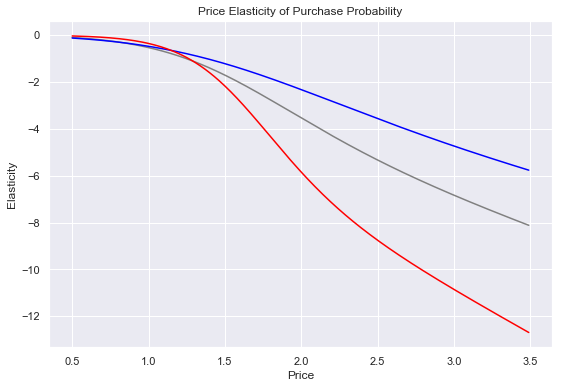

In [108]:
# We plot the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in blue. 
# The Few opportunity segment is displayed in red. 
plt.figure(figsize = (9, 6))
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['Mean_PE'], color = 'grey')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_CF'], color = 'blue')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_Few'], color = 'red')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

### It is evident that this segment is too much price sensitive and that it becomes inelastic at 1.27 which is little more than the overall customer's so we could hypothesize that due to this segment only the overall price point has been low.

### $\color{green}{\textbf{Segment 2 - Well-Off}}$

In [109]:
# Select only customers from segment 2, the Well-Off.
df_pa_segment_2 = df_pa[df_pa['Segment Label'] == 'Well-off']

In [110]:
# Logistic regression model
Y = df_pa_segment_2['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5

model_incidence_segment2 = LogisticRegression(solver = 'sag')
model_incidence_segment2.fit(X, Y)

# Calculate price elasticities
model_incidence_segment2.coef_
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[: , 1]
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range * ( 1- purchase_pr_segment2)

### Results

In [111]:
df_price_elasticities['PE_Segment_Well'] = pe_segment2
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few,PE_Segment_Well
0,0.50,-0.096372,-0.119130,-0.030930,-0.168036
1,0.51,-0.100439,-0.123314,-0.032698,-0.172960
2,0.52,-0.104633,-0.127591,-0.034552,-0.177955
3,0.53,-0.108957,-0.131962,-0.036497,-0.183020
4,0.54,-0.113414,-0.136430,-0.038537,-0.188157
5,0.55,-0.118008,-0.140996,-0.040676,-0.193366
6,0.56,-0.122741,-0.145661,-0.042918,-0.198647
7,0.57,-0.127618,-0.150427,-0.045269,-0.204000
8,0.58,-0.132641,-0.155294,-0.047731,-0.209427
9,0.59,-0.137814,-0.160266,-0.050312,-0.214927


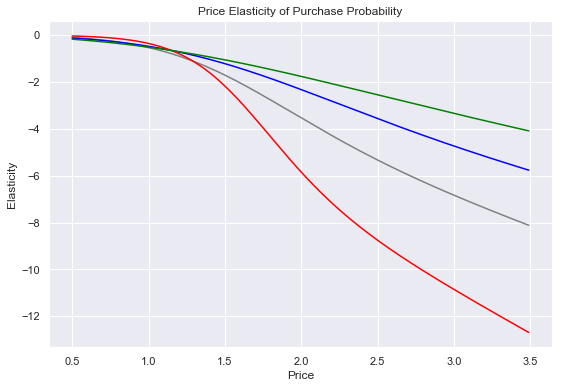

In [112]:
# We plot the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in blue. 
# The Few opportunity segment is displayed in red. 
# The Well Off segment is displayed in red. 

plt.figure(figsize = (9, 6))
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['Mean_PE'], color = 'grey')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_CF'], color = 'blue')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_Few'], color = 'red')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_Well'], color = 'green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

### It is evident that Well off segment is highly insensitive to price change and that it becomes  in elastic at 1.46 which is the highest price point than other segments

### $\color{orange}{\textbf{Segment 1 - Standard}}$

In [113]:
# Select only customers from segment 1, the Standard.
df_pa_segment_1 = df_pa[df_pa['Segment Label'] == 'Standard']

In [114]:
# Logistic regression model
Y = df_pa_segment_1['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

model_incidence_segment1 = LogisticRegression(solver = 'sag')
model_incidence_segment1.fit(X, Y)

# Calculate price elasticities
model_incidence_segment1.coef_
Y_segment_1 = model_incidence_segment1.predict_proba(df_price_range)
purchase_pr_segment1 = Y_segment_1[: , 1]
pe_segment1 = model_incidence_segment1.coef_[:,0] * price_range * ( 1- purchase_pr_segment1)

### Results

In [115]:
df_price_elasticities['PE_Segment_Standard'] = pe_segment1
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few,PE_Segment_Well,PE_Segment_Standard
0,0.50,-0.096372,-0.119130,-0.030930,-0.168036,-0.211108
1,0.51,-0.100439,-0.123314,-0.032698,-0.172960,-0.217676
2,0.52,-0.104633,-0.127591,-0.034552,-0.177955,-0.224352
3,0.53,-0.108957,-0.131962,-0.036497,-0.183020,-0.231137
4,0.54,-0.113414,-0.136430,-0.038537,-0.188157,-0.238031
5,0.55,-0.118008,-0.140996,-0.040676,-0.193366,-0.245034
6,0.56,-0.122741,-0.145661,-0.042918,-0.198647,-0.252149
7,0.57,-0.127618,-0.150427,-0.045269,-0.204000,-0.259375
8,0.58,-0.132641,-0.155294,-0.047731,-0.209427,-0.266714
9,0.59,-0.137814,-0.160266,-0.050312,-0.214927,-0.274165


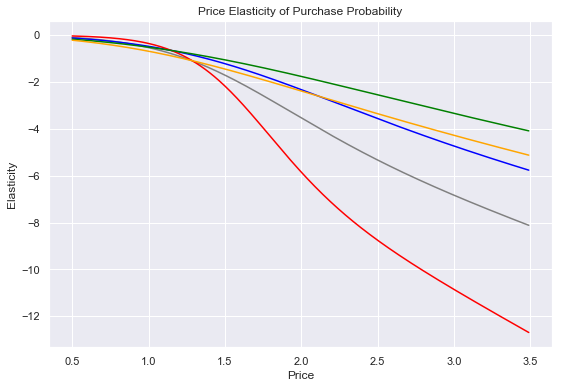

In [116]:
# We plot the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in blue. 
# The Few opportunity segment is displayed in red. 
# The Well Off segment is displayed in red. 
# The Standard segment is displayed in red. 


plt.figure(figsize = (9, 6))
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['Mean_PE'], color = 'grey')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_CF'], color = 'blue')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_Few'], color = 'red')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_Well'], color = 'green')
plt.plot(df_price_elasticities['Price_Point'], df_price_elasticities['PE_Segment_Standard'], color = 'orange')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

### It is evident that Standard segment is between average and career focussed in response to price change and that it becomes  in elastic at 1.24 

# Purchase Probability with Promotion Feature

### Data Preparation

In [117]:
Y = df_pa['Incidence']

In [118]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5']) / 5

In [119]:
# We include a second promotion feature. We'd like to examine the effects of promotions on purchase probability.
# We then calculate the average promotion rate across the five brands. We add the mean price for the brands.
X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'] ) / 5
X.head()

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0


## Model Estimation

In [120]:
# The coefficient for promotion is positive. 
# Therefore, there is a positive relationship between promotion and purchase probability.
model_incidence_promotion = LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X, Y)
model_incidence_promotion.coef_

array([[-1.49393532,  0.56143488]])

## Price Elasticity with Promotion

In [121]:
# We create a data frame on which our model will predict. We need to include A price and promotion feature.
# First, we'll include the price range as the price feature. Next, we'll include the promotion feature.
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion.rename(columns = {0: "Price_Range"})

In [122]:
# We'll calculate price elasticities of purchase probability when we assume there is a promotion across at each price points.
df_price_elasticity_promotion['Promotion'] = 1

In [123]:
# Purchase Probability with Promotion Model Prediction
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)

In [124]:
promo = Y_promotion[:, 1]
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo)

In [125]:
# Update master data to include elasticities of purchase probability with promotion feature
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few,PE_Segment_Well,PE_Segment_Standard,Elasticity_Promotion_1
0,0.50,-0.096372,-0.119130,-0.030930,-0.168036,-0.211108,-0.125751
1,0.51,-0.100439,-0.123314,-0.032698,-0.172960,-0.217676,-0.129868
2,0.52,-0.104633,-0.127591,-0.034552,-0.177955,-0.224352,-0.134064
3,0.53,-0.108957,-0.131962,-0.036497,-0.183020,-0.231137,-0.138339
4,0.54,-0.113414,-0.136430,-0.038537,-0.188157,-0.238031,-0.142695
5,0.55,-0.118008,-0.140996,-0.040676,-0.193366,-0.245034,-0.147134
6,0.56,-0.122741,-0.145661,-0.042918,-0.198647,-0.252149,-0.151655
7,0.57,-0.127618,-0.150427,-0.045269,-0.204000,-0.259375,-0.156260
8,0.58,-0.132641,-0.155294,-0.047731,-0.209427,-0.266714,-0.160950
9,0.59,-0.137814,-0.160266,-0.050312,-0.214927,-0.274165,-0.165726


## Price Elasticity without Promotion

In [126]:
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = df_price_elasticity_promotion_no.rename(columns = {0: "Price_Range"})

In [127]:
# Promotion feature -No Promotion.
# We assume there aren't any promotional activities on any of the price points.
# We examine the elasticity of purchase probability when there isn't promotion.
df_price_elasticity_promotion_no['Promotion'] = 0

In [128]:
#Purchase Probability without Promotion Model Prediction
Y_no_promo = model_incidence_promotion.predict_proba(df_price_elasticity_promotion_no)

In [129]:
no_promo = Y_no_promo[: , 1]

In [130]:
price_elasticity_no_promo = model_incidence_promotion.coef_[:, 0] * price_range *(1- no_promo)

In [131]:
# Update master data frame to include purchase probability elasticities without promotion.
# We can now see the values with and without promotion and compare them for each price point in our price range.
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few,PE_Segment_Well,PE_Segment_Standard,Elasticity_Promotion_1,Elasticity_Promotion_0
0,0.50,-0.096372,-0.119130,-0.030930,-0.168036,-0.211108,-0.125751,-0.195657
1,0.51,-0.100439,-0.123314,-0.032698,-0.172960,-0.217676,-0.129868,-0.201778
2,0.52,-0.104633,-0.127591,-0.034552,-0.177955,-0.224352,-0.134064,-0.208002
3,0.53,-0.108957,-0.131962,-0.036497,-0.183020,-0.231137,-0.138339,-0.214329
4,0.54,-0.113414,-0.136430,-0.038537,-0.188157,-0.238031,-0.142695,-0.220761
5,0.55,-0.118008,-0.140996,-0.040676,-0.193366,-0.245034,-0.147134,-0.227297
6,0.56,-0.122741,-0.145661,-0.042918,-0.198647,-0.252149,-0.151655,-0.233939
7,0.57,-0.127618,-0.150427,-0.045269,-0.204000,-0.259375,-0.156260,-0.240687
8,0.58,-0.132641,-0.155294,-0.047731,-0.209427,-0.266714,-0.160950,-0.247543
9,0.59,-0.137814,-0.160266,-0.050312,-0.214927,-0.274165,-0.165726,-0.254507


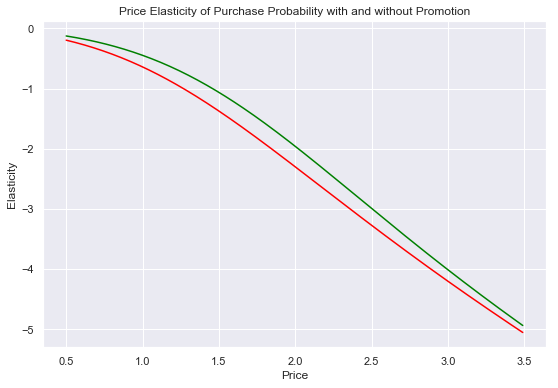

In [132]:
# Plot purchase elasticities with and without promotion side by side for comparison.
# With out promotion is red
# With promotion is green

plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_no_promo, color='red')
plt.plot(price_range, price_elasticity_promo, color='green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability with and without Promotion')
plt.show()

### Here we observe that the purchase probability elasticity of the customer is less elastic when there is promotion.This is an important insight for marketers, as according to our model people are more likely to buy a product if there is some promotional activity rather than purchase a product with the same price, when it isn't on promotion. 


## ----------------------------------------------------------------------------------------------------------------------

## ${\textbf{Brand Choice}}$

### Data Preparation

In [133]:
# Here we are interested in determining the brand choice of the customer. 
# Hence, we filter our data, to include only purchase occasion, when a purchase has occured. 
brand_choice = df_pa[df_pa['Incidence'] == 1]

In [134]:
# We cap the maximum displayed rows in a table, to make computation more efficient and easier readability.
pd.options.display.max_rows = 100
brand_choice

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Segment Label
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,2.09,2.67,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,2.12,2.62,1,0,0,0,1,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,1.97,2.67,0,0,0,1,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,2.16,2.68,1,1,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,1.89,2.37,1,0,0,1,1,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
52,200000001,327,1,4,3,0,0,1.47,1.89,2.01,1.90,2.71,0,0,0,1,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
79,200000001,547,1,2,2,0,0,1.35,1.89,2.07,2.26,2.63,1,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
80,200000001,562,1,2,3,2,1,1.33,1.51,2.07,2.26,2.62,1,1,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
97,200000001,702,1,5,1,0,0,1.41,1.85,2.00,2.24,2.79,0,0,1,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
101,200000002,6,1,4,1,0,0,1.59,1.87,2.01,2.09,2.66,0,0,0,0,0,1,1,52,2,159052,2,1,2,0,0,1,0,Well-off


In [135]:
# Our model will predict the brand. So Y is the brand choice
Y = brand_choice['Brand']

In [50]:
# Here we decide which features to include for prediction.
brand_choice.columns.values

array(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3'], dtype=object)

In [136]:
# We predict based on the prices for the five brands.
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = brand_choice[features]

In [137]:
# Brand Choice Model fit.
model_brand_choice = LogisticRegression(solver = 'sag', multi_class = 'multinomial')
model_brand_choice.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [138]:
# Here are the coeffictients for the model. We have five brands and five features for the price. 
# Therefore, this output is somewhat difficult to read.
model_brand_choice.coef_

array([[-3.91595755,  0.65846015,  2.41771911,  0.70408661, -0.20210424],
       [ 1.27461122, -1.87985512, -0.21264721, -0.20634086,  0.58787168],
       [ 1.62419221,  0.56210865,  0.50089151,  1.03950662,  0.4527794 ],
       [ 0.57453541,  0.39558786, -1.40061056, -1.2462446 ,  0.24935153],
       [ 0.44261872,  0.26369846, -1.30535285, -0.29100777, -1.08789837]])

In [139]:
# We create a pandas data frame, which contains to coefficients.
bc_coef = pd.DataFrame(model_brand_choice.coef_)
bc_coef

,0,1,2,3,4
0,-3.915958,0.658460,2.417719,0.704087,-0.202104
1,1.274611,-1.879855,-0.212647,-0.206341,0.587872
2,1.624192,0.562109,0.500892,1.039507,0.452779
3,0.574535,0.395588,-1.400611,-1.246245,0.249352
4,0.442619,0.263698,-1.305353,-0.291008,-1.087898


In [140]:
# We make some transformations on the coefficients data frame to increase readability.
# We transpose the data frame, to keep with the conventional representation of results.
# We add labels for the columns and the index, which represent the coefficients of the brands and prices, respectively. 
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
coefficients = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
bc_coef.columns = [coefficients]
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


## Own Price Elasticity Brand 5

In [141]:
# We want to calculate price elasticity of brand choice.
# Here we create a data frame with price columns, which our model will use to predict the brand choice probabilities.
# Here we have kept the prices of all brands constant except brand 5 on which we need to predict
df_own_brand_5 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range
df_own_brand_5

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54
5,1.384559,1.764717,2.006694,2.159658,0.55
6,1.384559,1.764717,2.006694,2.159658,0.56
7,1.384559,1.764717,2.006694,2.159658,0.57
8,1.384559,1.764717,2.006694,2.159658,0.58
9,1.384559,1.764717,2.006694,2.159658,0.59


In [142]:
# Brand Choice Model prediction.
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)

In [146]:
# Our model returns the probabilities of choosing each of the 5 brands. 
# Since, we are interested in the probability for the fifth brand we need to obtain the last column located on position 4,
pr_own_brand_5 = predict_brand_5[:, 4]

In [147]:
# We're interested in choosing brand 5. 
# Therefore, the beta coefficient we require is that of the brand 5 coefficient and price 5.
beta5 = bc_coef.iloc[4, 4]
beta5

-1.09

In [148]:
# Calculating price elasticities for brand choice without promotion. 
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pr_own_brand_5)

In [149]:
# Adding the price elasticities to our master data frame. 
df_price_elasticities['Brand_5'] = own_price_elasticity_brand_5
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few,PE_Segment_Well,PE_Segment_Standard,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5
0,0.50,-0.096372,-0.119130,-0.030930,-0.168036,-0.211108,-0.125751,-0.195657,-0.049055
1,0.51,-0.100439,-0.123314,-0.032698,-0.172960,-0.217676,-0.129868,-0.201778,-0.050616
2,0.52,-0.104633,-0.127591,-0.034552,-0.177955,-0.224352,-0.134064,-0.208002,-0.052207
3,0.53,-0.108957,-0.131962,-0.036497,-0.183020,-0.231137,-0.138339,-0.214329,-0.053827
4,0.54,-0.113414,-0.136430,-0.038537,-0.188157,-0.238031,-0.142695,-0.220761,-0.055477
5,0.55,-0.118008,-0.140996,-0.040676,-0.193366,-0.245034,-0.147134,-0.227297,-0.057158
6,0.56,-0.122741,-0.145661,-0.042918,-0.198647,-0.252149,-0.151655,-0.233939,-0.058871
7,0.57,-0.127618,-0.150427,-0.045269,-0.204000,-0.259375,-0.156260,-0.240687,-0.060615
8,0.58,-0.132641,-0.155294,-0.047731,-0.209427,-0.266714,-0.160950,-0.247543,-0.062391
9,0.59,-0.137814,-0.160266,-0.050312,-0.214927,-0.274165,-0.165726,-0.254507,-0.064200


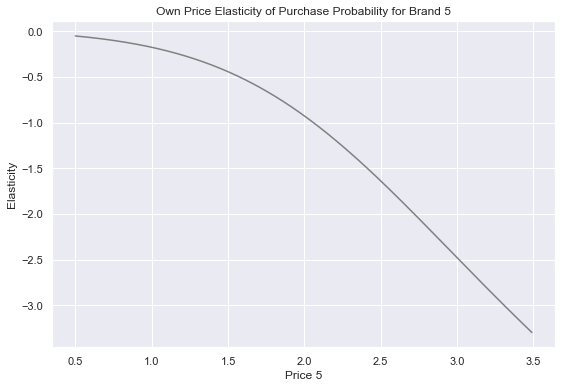

In [151]:
# Plot elasticities of purchase probability for brand 5.
plt.figure(figsize = (9, 6))
plt.plot(price_range, df_price_elasticities['Brand_5'], color = 'grey')
plt.xlabel('Price 5')
plt.ylabel('Elasticity')
plt.title('Own Price Elasticity of Purchase Probability for Brand 5')
plt.show()

### It is obvious that customers who choose brand 5 are the customers who are inelastic at high price points, that is slight increase in the prices won't sway away this customers from brand 5. However, it would be interesting to know if the competitors changed their prices then how likely are this customers to buy their product

## Cross Price Elasticity Brand 5, Cross Brand 4

In [152]:
# We want to examine the effect of the changes in price of a competitor brand.
# As we've discussed in the lecture, the brand which comes closest to brand 5 is brand 4. 
# Therefore, we need to examine changes in the price of this brand.
# Keep in mind, we could examine the cross price elasticities for any of the remaining brands as well, 
# we just need to update this data frame accordingly to contain the respective brand.
# Here we keep the prices of all brand constant except brand 4.
df_brand5_cross_brand4 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4['Price_1'] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4['Price_2'] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4['Price_3'] = brand_choice['Price_3'].mean()
df_brand5_cross_brand4['Price_4'] = price_range
df_brand5_cross_brand4['Price_5'] = brand_choice['Price_5'].mean()

In [153]:
df_brand5_cross_brand4.head()

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,0.50,2.654296
1,1.384559,1.764717,2.006694,0.51,2.654296
2,1.384559,1.764717,2.006694,0.52,2.654296
3,1.384559,1.764717,2.006694,0.53,2.654296
4,1.384559,1.764717,2.006694,0.54,2.654296


In [154]:
predict_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)

In [155]:
# As now we're interested in what the probability of choosing the competitor brand is, 
# we need to select the purchase probability for brand 4, contained in the 4th column with index 3. 
pr_brand_4 = predict_brand5_cross_brand4[:][:, 3]

In [156]:
beta5

-1.09

In [157]:
# In order to calculate the cross brand price elasticity, we need to use the new formula we introduced in the lecture.
# The elasticity is equal to negative the price coefficient of the own brand multiplied by the price of the cross brand,
# further multiplied by the probability for choosing the cross brand.
brand5_cross_brand4_price_elasticity = -beta5 * price_range * pr_brand_4

In [158]:
# Update price elasticities data frame to include the cross price elasticities for brand 5 with respect to brand 4.
df_price_elasticities['Brand_5_Cross_Brand_4'] = brand5_cross_brand4_price_elasticity
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few,PE_Segment_Well,PE_Segment_Standard,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4
0,0.50,-0.096372,-0.119130,-0.030930,-0.168036,-0.211108,-0.125751,-0.195657,-0.049055,0.332011
1,0.51,-0.100439,-0.123314,-0.032698,-0.172960,-0.217676,-0.129868,-0.201778,-0.050616,0.337288
2,0.52,-0.104633,-0.127591,-0.034552,-0.177955,-0.224352,-0.134064,-0.208002,-0.052207,0.342507
3,0.53,-0.108957,-0.131962,-0.036497,-0.183020,-0.231137,-0.138339,-0.214329,-0.053827,0.347669
4,0.54,-0.113414,-0.136430,-0.038537,-0.188157,-0.238031,-0.142695,-0.220761,-0.055477,0.352773
5,0.55,-0.118008,-0.140996,-0.040676,-0.193366,-0.245034,-0.147134,-0.227297,-0.057158,0.357820
6,0.56,-0.122741,-0.145661,-0.042918,-0.198647,-0.252149,-0.151655,-0.233939,-0.058871,0.362809
7,0.57,-0.127618,-0.150427,-0.045269,-0.204000,-0.259375,-0.156260,-0.240687,-0.060615,0.367741
8,0.58,-0.132641,-0.155294,-0.047731,-0.209427,-0.266714,-0.160950,-0.247543,-0.062391,0.372614
9,0.59,-0.137814,-0.160266,-0.050312,-0.214927,-0.274165,-0.165726,-0.254507,-0.064200,0.377430


Text(0.5, 1.0, 'Cross Price Elasticity of Brand 5 wrt Brand 4')

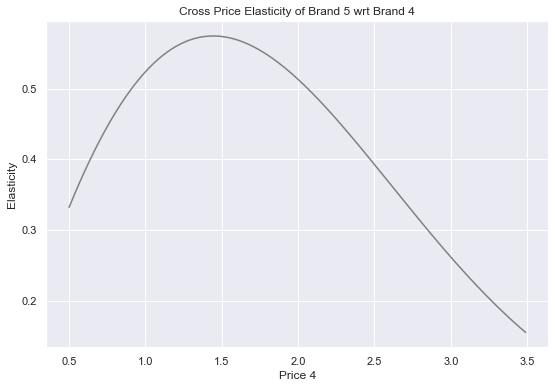

In [70]:
# Here we examine the cross price elasticity of purchase probability for brand 5 with respect to brand 4.
# We observe they are positive. As the price of the competitor brand increases, 
# so does the probability for purchasing our own brand.
# Even though the elasticity starts to decrease from the 1.45 mark, it is still positive, 
# signalling that the increase in purchase probability for the own brand happens more slowly.
plt.figure(figsize = (9, 6))
plt.plot(price_range, brand5_cross_brand4_price_elasticity, color = 'grey')
plt.xlabel('Price 4')
plt.ylabel('Elasticity')
plt.title('Cross Price Elasticity of Brand 5 wrt Brand 4')

### It is observed that the elasticities are positive indicates that as the competitor increases its price, the purchase probability of our product is more. However, until   $1.65 Elasticity of cross band is more than own brand so brand 4 is a strong subsitute for brand 5 till this price point. But, we can safely neglect this result since the min price for brand 4 is {$} 1.76, meaning that until and unless brand 4 doesn't drastically decreases its prices, our customer will remain loyal. 

### In the price domain of brand 4 (1.76 - 2.26), the elasticity steadily decreases meaning that own brand purchase probability increases with increase in brand 4 prices.


## Own and Cross-Price Elasticity by Segment

### $\color{orange}{\text{Well-Off}}$

In [161]:
# We are interested in analysing the purchase probability for choosing brand 5 by segments.
# We filter our data to contain only purchase incidences of the third segment - Well-off.
brand_choice_wo = df_pa[df_pa['Incidence'] == 1]
brand_choice_wo = brand_choice_wo[brand_choice_wo['Segment Label'] == 'Well-off']

pd.options.display.max_rows = 100
brand_choice_wo.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Segment Label
101,200000002,6,1,4,1,0,0,1.59,1.87,2.01,2.09,2.66,0,0,0,0,0,1,1,52,2,159052,2,1,2,0,0,1,0,Well-off
115,200000002,100,1,4,2,0,0,1.47,1.90,1.95,2.12,2.67,0,0,0,1,0,1,1,52,2,159052,2,1,2,0,0,1,0,Well-off
138,200000002,283,1,4,3,0,0,1.37,1.89,2.00,2.14,2.64,0,0,0,0,0,1,1,52,2,159052,2,1,2,0,0,1,0,Well-off
141,200000002,307,1,4,1,0,0,1.34,1.89,2.01,2.03,2.68,1,0,0,1,0,1,1,52,2,159052,2,1,2,0,0,1,0,Well-off
153,200000002,422,1,4,1,0,0,1.34,1.89,2.02,2.21,2.65,0,0,0,1,0,1,1,52,2,159052,2,1,2,0,0,1,0,Well-off


In [162]:
# Brand Choice Model estimation.
Y = brand_choice_wo['Brand']
brand_choice_wo = pd.get_dummies(brand_choice_wo, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_wo[features]
model_brand_choice_wo = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_wo.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_wo.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.15,1.33,0.82,0.12,-0.11
Price_2,-0.96,-1.38,1.29,0.78,0.27
Price_3,2.01,-1.65,-0.49,0.03,0.11
Price_4,2.52,0.96,-0.25,-1.90,-1.33
Price_5,-0.99,-0.30,1.17,0.56,-0.44


### $\color{orange}{\text{Own-Brand Price Elasticity}}$

In [163]:
# Calculating own-brand price elasticity for brand 5 and the Well-off segment.
df_own_brand_5_wo = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_wo['Price_1'] = brand_choice_wo['Price_1'].mean()
df_own_brand_5_wo['Price_2'] = brand_choice_wo['Price_2'].mean()
df_own_brand_5_wo['Price_3'] = brand_choice_wo['Price_3'].mean()
df_own_brand_5_wo['Price_4'] = brand_choice_wo['Price_4'].mean()
df_own_brand_5_wo['Price_5'] = price_range

predict_own_brand_5_wo = model_brand_choice_wo.predict_proba(df_own_brand_5_wo)
pr_own_brand_5_wo = predict_own_brand_5_wo[: ][: , 4]

own_price_elasticity_brand_5_wo =  beta5 * price_range * (1 - pr_own_brand_5_wo)
df_price_elasticities['Brand 5 wo'] = own_price_elasticity_brand_5_wo

### $\color{orange}{\text{Cross-Brand Price Elasticity}}$

In [164]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
df_brand5_cross_brand4_wo = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_wo['Price_1'] = brand_choice_wo['Price_1'].mean()
df_brand5_cross_brand4_wo['Price_2'] = brand_choice_wo['Price_2'].mean()
df_brand5_cross_brand4_wo['Price_3'] = brand_choice_wo['Price_3'].mean()
df_brand5_cross_brand4_wo['Price_4'] = price_range
df_brand5_cross_brand4_wo['Price_5'] = brand_choice_wo['Price_5'].mean()

predict_brand5_cross_brand4_wo = model_brand_choice_wo.predict_proba(df_brand5_cross_brand4_wo)
pr_cross_brand_5_wo = predict_brand5_cross_brand4_wo[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_wo = -beta5 * price_range * pr_cross_brand_5_wo
df_price_elasticities['Brand_5_Cross_Brand_4_wo'] = brand5_cross_brand4_price_elasticity_wo
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few,PE_Segment_Well,PE_Segment_Standard,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 wo,Brand_5_Cross_Brand_4_wo
0,0.50,-0.096372,-0.119130,-0.030930,-0.168036,-0.211108,-0.125751,-0.195657,-0.049055,0.332011,-0.297316,0.482421
1,0.51,-0.100439,-0.123314,-0.032698,-0.172960,-0.217676,-0.129868,-0.201778,-0.050616,0.337288,-0.303362,0.491726
2,0.52,-0.104633,-0.127591,-0.034552,-0.177955,-0.224352,-0.134064,-0.208002,-0.052207,0.342507,-0.309418,0.501016
3,0.53,-0.108957,-0.131962,-0.036497,-0.183020,-0.231137,-0.138339,-0.214329,-0.053827,0.347669,-0.315485,0.510290
4,0.54,-0.113414,-0.136430,-0.038537,-0.188157,-0.238031,-0.142695,-0.220761,-0.055477,0.352773,-0.321563,0.519548
5,0.55,-0.118008,-0.140996,-0.040676,-0.193366,-0.245034,-0.147134,-0.227297,-0.057158,0.357820,-0.327653,0.528790
6,0.56,-0.122741,-0.145661,-0.042918,-0.198647,-0.252149,-0.151655,-0.233939,-0.058871,0.362809,-0.333754,0.538016
7,0.57,-0.127618,-0.150427,-0.045269,-0.204000,-0.259375,-0.156260,-0.240687,-0.060615,0.367741,-0.339868,0.547226
8,0.58,-0.132641,-0.155294,-0.047731,-0.209427,-0.266714,-0.160950,-0.247543,-0.062391,0.372614,-0.345994,0.556420
9,0.59,-0.137814,-0.160266,-0.050312,-0.214927,-0.274165,-0.165726,-0.254507,-0.064200,0.377430,-0.352133,0.565597


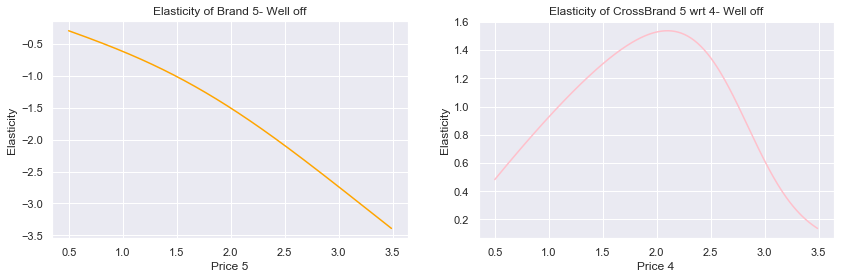

In [170]:
fig, axs = plt.subplots(1, 2, figsize = (14,4))
axs[0].plot(price_range, df_price_elasticities['Brand 5 wo'], color='orange')
axs[0].set_title('Elasticity of Brand 5- Well off')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, df_price_elasticities['Brand_5_Cross_Brand_4_wo'], color='pink')
axs[1].set_title('Elasticity of CrossBrand 5 wrt 4- Well off')
axs[1].set_xlabel('Price 4')

for i in axs.flat:
    i.set(ylabel = 'Elasticity')

In [167]:
brand_choice[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000
mean,1.384559,1.764717,2.006694,2.159658,2.654296
std,0.090944,0.181667,0.046200,0.093253,0.097724
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.570000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.180000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


### Since Brand 4 has domain between (1.76, 2.26), it is evident from the cross brand elasticities that under this price range, brand 5 will definitely isn't losing its customers to brand 4. However, if suppose that brand 4 decides to reduce its price by 1% from 2$ initially then the probability that we will losing our customers will be equal to value of elasticity at that price point(lets say 1.5%).

### To cope up with that if we decided to reduce our price by 1%, let's say from initial 2.5$ then probability then we will retain our customers is value of elasticity (lets say 2%), so net effect would be (2 - 1.5)% = 0.5% meaning, after reacting to our competitor's price change, we will be gaining 0.5% market share.

### But suppose if you would like to keep our customer probability constant, then we can probably devise an equation i.e. x * 2 = 1.5%, where x is the percent we need to reduce in order to react to competitor's price change and keeping our customer probability constant, 2 is the competitor's original price and 1.5% is the elasticity. 1.5%/2 = 0.75%, implies that we can reduce the price of our product by 0.75% and still have the same probability of purchase of our customers.  

### $\color{blue}{\text{Standard}}$

In [171]:
# Here we are interesting in analysing the brand choice probability of the Standard segment.
# We filter our data, by selecting only purchases from segment 0.
# We are interested in analysing the purchase probability for choosing brand 5 by segments.
# We filter our data to contain only purchase incidences of the third segment - Well-off.
brand_choice_st = df_pa[df_pa['Incidence'] == 1]
brand_choice_st = brand_choice_st[brand_choice_st['Segment Label'] == 'Standard']

pd.options.display.max_rows = 100
brand_choice_st.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Segment Label
2398,200000024,44,1,2,2,0,0,1.35,1.58,1.97,2.09,2.67,1,1,1,0,0,1,1,32,1,88428,0,0,1,0,1,0,0,Standard
2403,200000024,98,1,2,2,0,0,1.47,1.90,1.95,2.12,2.67,0,0,0,0,0,1,1,32,1,88428,0,0,1,0,1,0,0,Standard
2408,200000024,143,1,2,3,0,0,1.21,1.35,1.99,2.16,2.67,1,1,0,0,0,1,1,32,1,88428,0,0,1,0,1,0,0,Standard
2410,200000024,162,1,2,5,0,0,1.39,1.90,1.94,2.16,2.49,1,0,0,0,0,1,1,32,1,88428,0,0,1,0,1,0,0,Standard
2417,200000024,217,1,5,1,0,0,1.34,1.89,1.99,2.13,2.67,0,0,0,0,0,1,1,32,1,88428,0,0,1,0,1,0,0,Standard


In [172]:
# Brand Choice Model estimation.
Y = brand_choice_st['Brand']
brand_choice_st = pd.get_dummies(brand_choice_st, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_st[features]
model_brand_choice_st = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_st.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_st.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.01,1.09,1.19,0.27,0.47
Price_2,0.75,-2.06,0.46,0.37,0.48
Price_3,1.20,-0.50,0.36,-0.06,-1.00
Price_4,0.44,-0.28,0.99,-1.25,0.11
Price_5,-0.07,1.40,0.68,-0.86,-1.15


### $\color{blue}{\text{Own-Brand Price Elasticity}}$

In [173]:
# Calculating own-brand price elasticity for brand 5 and the Well-off segment.
df_own_brand_5_st = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_st['Price_1'] = brand_choice_st['Price_1'].mean()
df_own_brand_5_st['Price_2'] = brand_choice_st['Price_2'].mean()
df_own_brand_5_st['Price_3'] = brand_choice_st['Price_3'].mean()
df_own_brand_5_st['Price_4'] = brand_choice_st['Price_4'].mean()
df_own_brand_5_st['Price_5'] = price_range

predict_own_brand_5_st = model_brand_choice_st.predict_proba(df_own_brand_5_st)
pr_own_brand_5_st = predict_own_brand_5_st[: ][: , 4]

own_price_elasticity_brand_5_st =  beta5 * price_range * (1 - pr_own_brand_5_st)
df_price_elasticities['Brand 5 st'] = own_price_elasticity_brand_5_st

### $\color{blue}{\text{Cross-Brand Price Elasticity}}$

In [174]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
df_brand5_cross_brand4_st = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_st['Price_1'] = brand_choice_st['Price_1'].mean()
df_brand5_cross_brand4_st['Price_2'] = brand_choice_st['Price_2'].mean()
df_brand5_cross_brand4_st['Price_3'] = brand_choice_st['Price_3'].mean()
df_brand5_cross_brand4_st['Price_4'] = price_range
df_brand5_cross_brand4_st['Price_5'] = brand_choice_st['Price_5'].mean()

predict_brand5_cross_brand4_st = model_brand_choice_st.predict_proba(df_brand5_cross_brand4_st)
pr_cross_brand_5_st = predict_brand5_cross_brand4_st[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_st = -beta5 * price_range * pr_cross_brand_5_st
df_price_elasticities['Brand_5_Cross_Brand_4_st'] = brand5_cross_brand4_price_elasticity_st
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few,PE_Segment_Well,PE_Segment_Standard,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 wo,Brand_5_Cross_Brand_4_wo,Brand 5 st,Brand_5_Cross_Brand_4_st
0,0.50,-0.096372,-0.119130,-0.030930,-0.168036,-0.211108,-0.125751,-0.195657,-0.049055,0.332011,-0.297316,0.482421,-0.115841,0.174127
1,0.51,-0.100439,-0.123314,-0.032698,-0.172960,-0.217676,-0.129868,-0.201778,-0.050616,0.337288,-0.303362,0.491726,-0.118880,0.176183
2,0.52,-0.104633,-0.127591,-0.034552,-0.177955,-0.224352,-0.134064,-0.208002,-0.052207,0.342507,-0.309418,0.501016,-0.121954,0.178187
3,0.53,-0.108957,-0.131962,-0.036497,-0.183020,-0.231137,-0.138339,-0.214329,-0.053827,0.347669,-0.315485,0.510290,-0.125063,0.180141
4,0.54,-0.113414,-0.136430,-0.038537,-0.188157,-0.238031,-0.142695,-0.220761,-0.055477,0.352773,-0.321563,0.519548,-0.128208,0.182045
5,0.55,-0.118008,-0.140996,-0.040676,-0.193366,-0.245034,-0.147134,-0.227297,-0.057158,0.357820,-0.327653,0.528790,-0.131389,0.183898
6,0.56,-0.122741,-0.145661,-0.042918,-0.198647,-0.252149,-0.151655,-0.233939,-0.058871,0.362809,-0.333754,0.538016,-0.134607,0.185702
7,0.57,-0.127618,-0.150427,-0.045269,-0.204000,-0.259375,-0.156260,-0.240687,-0.060615,0.367741,-0.339868,0.547226,-0.137861,0.187456
8,0.58,-0.132641,-0.155294,-0.047731,-0.209427,-0.266714,-0.160950,-0.247543,-0.062391,0.372614,-0.345994,0.556420,-0.141153,0.189162
9,0.59,-0.137814,-0.160266,-0.050312,-0.214927,-0.274165,-0.165726,-0.254507,-0.064200,0.377430,-0.352133,0.565597,-0.144483,0.190819


### $\color{green}{\text{Career-Focused}}$

In [179]:
# Here we are interecfing in analysing the brand choice probability of the cfandard segment.
# We filter our data, by selecting only purchases from segment 0.
# We are interecfed in analysing the purchase probability for choosing brand 5 by segments.
# We filter our data to contain only purchase incidences of the third segment - Well-off.
brand_choice_cf = df_pa[df_pa['Incidence'] == 1]
brand_choice_cf = brand_choice_cf[brand_choice_cf['Segment Label'] == 'Career-focussed']

pd.options.display.max_rows = 100
brand_choice_cf.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Segment Label
376,200000005,51,1,5,1,0,0,1.35,1.87,1.93,2.09,2.59,1,1,1,0,0,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed
377,200000005,57,1,5,1,5,1,1.39,1.90,1.91,2.12,2.62,1,0,0,0,0,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed
394,200000005,159,1,5,2,0,0,1.39,1.90,1.94,2.16,2.62,1,0,0,0,0,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed
396,200000005,178,1,5,3,0,0,1.48,1.50,1.99,2.16,2.49,0,0,0,1,1,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed
410,200000005,249,1,5,1,0,0,1.46,1.89,1.99,2.15,2.65,0,0,0,0,0,0,0,49,1,121466,1,2,3,0,0,0,1,Career-focussed


In [180]:
# Brand Choice Model ecfimation.
Y = brand_choice_cf['Brand']
brand_choice_cf = pd.get_dummies(brand_choice_cf, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_cf[features]
model_brand_choice_cf = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_cf.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_cf.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.38,1.13,1.39,-0.02,-0.11
Price_2,0.73,-1.65,0.05,0.40,0.47
Price_3,1.17,0.21,0.46,-1.71,-0.13
Price_4,0.03,0.65,0.41,-1.08,-0.01
Price_5,-0.00,-0.20,0.34,0.42,-0.55


### $\color{green}{\text{Own-Brand Price Elasticity}}$

In [182]:
# Calculating own-brand price elasticity for brand 5 and the Well-off segment.
df_own_brand_5_cf = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_cf['Price_1'] = brand_choice_cf['Price_1'].mean()
df_own_brand_5_cf['Price_2'] = brand_choice_cf['Price_2'].mean()
df_own_brand_5_cf['Price_3'] = brand_choice_cf['Price_3'].mean()
df_own_brand_5_cf['Price_4'] = brand_choice_cf['Price_4'].mean()
df_own_brand_5_cf['Price_5'] = price_range

predict_own_brand_5_cf = model_brand_choice_cf.predict_proba(df_own_brand_5_cf)
pr_own_brand_5_cf = predict_own_brand_5_st[: ][: , 4]

own_price_elasticity_brand_5_cf =  beta5 * price_range * (1 - pr_own_brand_5_cf)
df_price_elasticities['Brand 5 cf'] = own_price_elasticity_brand_5_cf

### $\color{green}{\text{Cross-Brand Price Elasticity}}$

In [183]:
# Calculating cross-brand price elacficity for brand 5 with respect to brand 4 for the Well-off segment.
df_brand5_cross_brand4_cf = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_cf['Price_1'] = brand_choice_cf['Price_1'].mean()
df_brand5_cross_brand4_cf['Price_2'] = brand_choice_cf['Price_2'].mean()
df_brand5_cross_brand4_cf['Price_3'] = brand_choice_cf['Price_3'].mean()
df_brand5_cross_brand4_cf['Price_4'] = price_range
df_brand5_cross_brand4_cf['Price_5'] = brand_choice_cf['Price_5'].mean()

predict_brand5_cross_brand4_cf = model_brand_choice_cf.predict_proba(df_brand5_cross_brand4_cf)
pr_cross_brand_5_cf = predict_brand5_cross_brand4_cf[: ][: , 3]

# Update macfer data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticities_cf = -beta5 * price_range * pr_cross_brand_5_cf
df_price_elasticities['Brand_5_Cross_Brand_4_cf'] = brand5_cross_brand4_price_elasticities_cf
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few,PE_Segment_Well,PE_Segment_Standard,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 wo,Brand_5_Cross_Brand_4_wo,Brand 5 st,Brand_5_Cross_Brand_4_st,Brand 5 cf,Brand_5_Cross_Brand_4_cf
0,0.50,-0.096372,-0.119130,-0.030930,-0.168036,-0.211108,-0.125751,-0.195657,-0.049055,0.332011,-0.297316,0.482421,-0.115841,0.174127,-0.115841,0.194772
1,0.51,-0.100439,-0.123314,-0.032698,-0.172960,-0.217676,-0.129868,-0.201778,-0.050616,0.337288,-0.303362,0.491726,-0.118880,0.176183,-0.118880,0.197256
2,0.52,-0.104633,-0.127591,-0.034552,-0.177955,-0.224352,-0.134064,-0.208002,-0.052207,0.342507,-0.309418,0.501016,-0.121954,0.178187,-0.121954,0.199689
3,0.53,-0.108957,-0.131962,-0.036497,-0.183020,-0.231137,-0.138339,-0.214329,-0.053827,0.347669,-0.315485,0.510290,-0.125063,0.180141,-0.125063,0.202072
4,0.54,-0.113414,-0.136430,-0.038537,-0.188157,-0.238031,-0.142695,-0.220761,-0.055477,0.352773,-0.321563,0.519548,-0.128208,0.182045,-0.128208,0.204404
5,0.55,-0.118008,-0.140996,-0.040676,-0.193366,-0.245034,-0.147134,-0.227297,-0.057158,0.357820,-0.327653,0.528790,-0.131389,0.183898,-0.131389,0.206686
6,0.56,-0.122741,-0.145661,-0.042918,-0.198647,-0.252149,-0.151655,-0.233939,-0.058871,0.362809,-0.333754,0.538016,-0.134607,0.185702,-0.134607,0.208918
7,0.57,-0.127618,-0.150427,-0.045269,-0.204000,-0.259375,-0.156260,-0.240687,-0.060615,0.367741,-0.339868,0.547226,-0.137861,0.187456,-0.137861,0.211101
8,0.58,-0.132641,-0.155294,-0.047731,-0.209427,-0.266714,-0.160950,-0.247543,-0.062391,0.372614,-0.345994,0.556420,-0.141153,0.189162,-0.141153,0.213236
9,0.59,-0.137814,-0.160266,-0.050312,-0.214927,-0.274165,-0.165726,-0.254507,-0.064200,0.377430,-0.352133,0.565597,-0.144483,0.190819,-0.144483,0.215321


### $\color{red}{\text{Fewer-Opportunities}}$

In [186]:
# Here we are interecfing in analysing the brand choice probability of the cfandard segment.
# We filter our data, by selecting only purchases from segment 0.
# We are interecfed in analysing the purchase probability for choosing brand 5 by segments.
# We filter our data to contain only purchase incidences of the third segment - Well-off.
brand_choice_fo = df_pa[df_pa['Incidence'] == 1]
brand_choice_fo = brand_choice_fo[brand_choice_fo['Segment Label'] == 'Fewer opportunity']

pd.options.display.max_rows = 100
brand_choice_fo.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Segment Label
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,2.09,2.67,0,0,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,2.12,2.62,1,0,0,0,1,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,1.97,2.67,0,0,0,1,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,2.16,2.68,1,1,0,0,0,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,1.89,2.37,1,0,0,1,1,0,0,47,1,110866,1,0,0,1,0,0,0,Fewer opportunity


In [187]:
# Brand Choice Model efoimation.
Y = brand_choice_fo['Brand']
brand_choice_fo = pd.get_dummies(brand_choice_fo, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_fo[features]
model_brand_choice_fo = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_fo.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_fo.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.95,1.63,1.12,0.21,0.99
Price_2,0.66,-2.13,0.07,0.25,1.15
Price_3,1.25,0.05,1.19,-0.31,-2.19
Price_4,1.31,-0.31,1.59,-1.58,-1.01
Price_5,0.93,1.28,0.19,0.52,-2.93


### $\color{red}{\text{Own-Brand Price Elasticity}}$

In [188]:
# Calculating own-brand price elasticity for brand 5 and the Well-off segment.
df_own_brand_5_fo = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_fo['Price_1'] = brand_choice_fo['Price_1'].mean()
df_own_brand_5_fo['Price_2'] = brand_choice_fo['Price_2'].mean()
df_own_brand_5_fo['Price_3'] = brand_choice_fo['Price_3'].mean()
df_own_brand_5_fo['Price_4'] = brand_choice_fo['Price_4'].mean()
df_own_brand_5_fo['Price_5'] = price_range

predict_own_brand_5_fo = model_brand_choice_fo.predict_proba(df_own_brand_5_fo)
pr_own_brand_5_fo = predict_own_brand_5_st[: ][: , 4]

own_price_elasticity_brand_5_fo =  beta5 * price_range * (1 - pr_own_brand_5_fo)
df_price_elasticities['Brand 5 fo'] = own_price_elasticity_brand_5_fo

### $\color{red}{\text{Cross-Brand Price Elasticity}}$

In [189]:
# Calculating cross-brand price elafoicity for brand 5 with respect to brand 4 for the Well-off segment.
df_brand5_cross_brand4_fo = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_fo['Price_1'] = brand_choice_fo['Price_1'].mean()
df_brand5_cross_brand4_fo['Price_2'] = brand_choice_fo['Price_2'].mean()
df_brand5_cross_brand4_fo['Price_3'] = brand_choice_fo['Price_3'].mean()
df_brand5_cross_brand4_fo['Price_4'] = price_range
df_brand5_cross_brand4_fo['Price_5'] = brand_choice_fo['Price_5'].mean()

predict_brand5_cross_brand4_fo = model_brand_choice_fo.predict_proba(df_brand5_cross_brand4_fo)
pr_cross_brand_5_fo = predict_brand5_cross_brand4_fo[: ][: , 3]

# Update mafoer data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticities_fo = -beta5 * price_range * pr_cross_brand_5_fo
df_price_elasticities['Brand_5_Cross_Brand_4_fo'] = brand5_cross_brand4_price_elasticities_fo
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_CF,PE_Segment_Few,PE_Segment_Well,PE_Segment_Standard,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 wo,Brand_5_Cross_Brand_4_wo,Brand 5 st,Brand_5_Cross_Brand_4_st,Brand 5 cf,Brand_5_Cross_Brand_4_cf,Brand 5 fo,Brand_5_Cross_Brand_4_fo
0,0.50,-0.096372,-0.119130,-0.030930,-0.168036,-0.211108,-0.125751,-0.195657,-0.049055,0.332011,-0.297316,0.482421,-0.115841,0.174127,-0.115841,0.194772,-0.115841,0.181592
1,0.51,-0.100439,-0.123314,-0.032698,-0.172960,-0.217676,-0.129868,-0.201778,-0.050616,0.337288,-0.303362,0.491726,-0.118880,0.176183,-0.118880,0.197256,-0.118880,0.183889
2,0.52,-0.104633,-0.127591,-0.034552,-0.177955,-0.224352,-0.134064,-0.208002,-0.052207,0.342507,-0.309418,0.501016,-0.121954,0.178187,-0.121954,0.199689,-0.121954,0.186137
3,0.53,-0.108957,-0.131962,-0.036497,-0.183020,-0.231137,-0.138339,-0.214329,-0.053827,0.347669,-0.315485,0.510290,-0.125063,0.180141,-0.125063,0.202072,-0.125063,0.188337
4,0.54,-0.113414,-0.136430,-0.038537,-0.188157,-0.238031,-0.142695,-0.220761,-0.055477,0.352773,-0.321563,0.519548,-0.128208,0.182045,-0.128208,0.204404,-0.128208,0.190488
5,0.55,-0.118008,-0.140996,-0.040676,-0.193366,-0.245034,-0.147134,-0.227297,-0.057158,0.357820,-0.327653,0.528790,-0.131389,0.183898,-0.131389,0.206686,-0.131389,0.192590
6,0.56,-0.122741,-0.145661,-0.042918,-0.198647,-0.252149,-0.151655,-0.233939,-0.058871,0.362809,-0.333754,0.538016,-0.134607,0.185702,-0.134607,0.208918,-0.134607,0.194645
7,0.57,-0.127618,-0.150427,-0.045269,-0.204000,-0.259375,-0.156260,-0.240687,-0.060615,0.367741,-0.339868,0.547226,-0.137861,0.187456,-0.137861,0.211101,-0.137861,0.196652
8,0.58,-0.132641,-0.155294,-0.047731,-0.209427,-0.266714,-0.160950,-0.247543,-0.062391,0.372614,-0.345994,0.556420,-0.141153,0.189162,-0.141153,0.213236,-0.141153,0.198612
9,0.59,-0.137814,-0.160266,-0.050312,-0.214927,-0.274165,-0.165726,-0.254507,-0.064200,0.377430,-0.352133,0.565597,-0.144483,0.190819,-0.144483,0.215321,-0.144483,0.200525


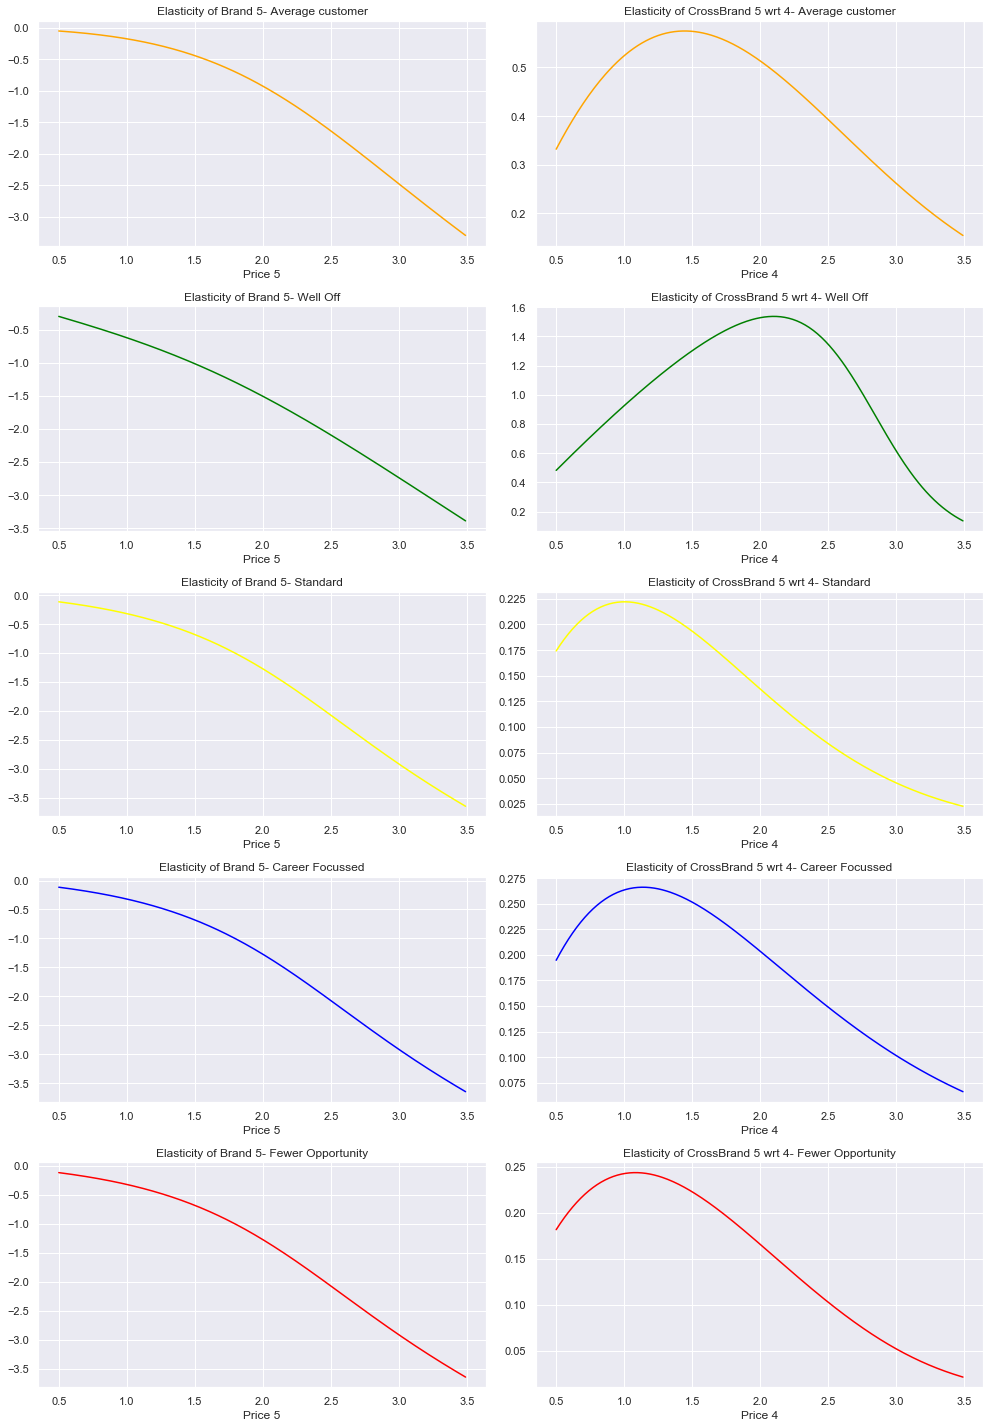

In [200]:
# We plot the own and cross brand price elasticities for the average customer and each of the four segments.
# We can observe differences and similiraties between the segments and examine their preference, when it comes to brand choice.
# The two segments, which seem to be of most interested for the marketing team of brand 5, seem to be the Career-focused
# and the Well-off. They are also the segments which purchase this brand most often. 
# The Career-focused segment is the most inelastic and they are the most loyal segment. 
# Based on our model, they do not seem to be that affected by price, therefore brand 5 could increase its price, 
# without fear of significant loss of customers from this segment. 
# The Well-off segment on the other hand, seems to be more elastic. They also purchase the competitor brand 4 most often.
# In order to target this segment, our analysis signals, that price needs to be decreased. However, keep in mind 
# that other factors aside from price might be influencing the purchase behaivour of this segment.
fig1, axs = plt.subplots(5, 2, figsize = (14,20))

# For Average customer
axs[0,1].plot(price_range, df_price_elasticities['Brand_5_Cross_Brand_4'], color='orange')
axs[0,1].set_title('Elasticity of CrossBrand 5 wrt 4- Average customer')
axs[0,1].set_xlabel('Price 4')

axs[0,0].plot(price_range, df_price_elasticities['Brand_5'], color='orange')
axs[0,0].set_title('Elasticity of Brand 5- Average customer')
axs[0,0].set_xlabel('Price 5')

# For Well Off segment
axs[1,1].plot(price_range, df_price_elasticities['Brand_5_Cross_Brand_4_wo'], color='green')
axs[1,1].set_title('Elasticity of CrossBrand 5 wrt 4- Well Off')
axs[1,1].set_xlabel('Price 4')

axs[1,0].plot(price_range, df_price_elasticities['Brand 5 wo'], color='green')
axs[1,0].set_title('Elasticity of Brand 5- Well Off')
axs[1,0].set_xlabel('Price 5')

# For Standard Segment
axs[2,1].plot(price_range, df_price_elasticities['Brand_5_Cross_Brand_4_st'], color='yellow')
axs[2,1].set_title('Elasticity of CrossBrand 5 wrt 4- Standard')
axs[2,1].set_xlabel('Price 4')

axs[2,0].plot(price_range, df_price_elasticities['Brand 5 st'], color='yellow')
axs[2,0].set_title('Elasticity of Brand 5- Standard')
axs[2,0].set_xlabel('Price 5')

# For career focussed Segment
axs[3,1].plot(price_range, df_price_elasticities['Brand_5_Cross_Brand_4_cf'], color='blue')
axs[3,1].set_title('Elasticity of CrossBrand 5 wrt 4- Career Focussed')
axs[3,1].set_xlabel('Price 4')

axs[3,0].plot(price_range, df_price_elasticities['Brand 5 cf'], color='blue')
axs[3,0].set_title('Elasticity of Brand 5- Career Focussed')
axs[3,0].set_xlabel('Price 5')

# For fewer opportunity
axs[4,1].plot(price_range, df_price_elasticities['Brand_5_Cross_Brand_4_fo'], color='red')
axs[4,1].set_title('Elasticity of CrossBrand 5 wrt 4- Fewer Opportunity')
axs[4,1].set_xlabel('Price 4')

axs[4,0].plot(price_range, df_price_elasticities['Brand 5 fo'], color='red')
axs[4,0].set_title('Elasticity of Brand 5- Fewer Opportunity')
axs[4,0].set_xlabel('Price 5')

plt.tight_layout()
    

In [ ]:
brand_dumm = pd.get_dummies(df_pa, columns='Brand', prefix='Brand', prefix_sep='_')
brand_dumm

In [ ]:
# plot heatmap to find corelation between brand and segment

plt.figure(figsize=(10,6))

sns.heatmap(df_pa)